# Burst DBS Helpers


In [88]:
# Importing Python and external packages


import os
import sys
import importlib
from importlib import reload 
from dataclasses import dataclass, field, fields
from itertools import compress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import scipy
from scipy import stats
from scipy import signal
from scipy.signal import spectrogram, butter, filtfilt, freqz
from scipy.signal.windows import hann

import seaborn as sns
import pingouin as pg
from itertools import combinations
#from statannotations.Annotator import Annotator

import openpyxl
from openpyxl import Workbook, load_workbook
# import xlrd
import pickle
import json
import csv
import fooof
from fooof.plts.spectra import plot_spectrum

#mne
import mne
from mne.time_frequency import tfr_morlet 

# xdf
import pyxdf
import pyxdftools
from pyxdftools import XdfData

import datetime

In [113]:
jennifer_user_path = os.getcwd()
while jennifer_user_path[-14:] != 'jenniferbehnke':
    jennifer_user_path = os.path.dirname(jennifer_user_path)

# directory to this Repository
project_path = os.path.join(jennifer_user_path, 'code', 'Patterned_stimulation_project', 'patterned_DBS')
sys.path.append(project_path)

os.chdir(project_path)

# patterned DBS
import src.patterned_DBS.beta_suppression_latency.patterned_dbs_pilot as pilot
import src.patterned_DBS.beta_suppression_latency.patterned_find_dbs_OFF_moment as find_dbs_OFF_moment

# utility functions
import src.patterned_DBS.utils.io as io
import src.patterned_DBS.utils.find_folders as find_folders
import src.patterned_DBS.utils.lfp_preprocessing as lfp_preprocessing
import src.patterned_DBS.utils.xdf_structure as xdf_structure

importlib.reload(pilot)
importlib.reload(find_dbs_OFF_moment)
importlib.reload(io)
importlib.reload(find_folders)
importlib.reload(lfp_preprocessing)
importlib.reload(xdf_structure)

<module 'src.patterned_DBS.utils.xdf_structure' from '/Users/jenniferbehnke/code/Patterned_stimulation_project/patterned_DBS/src/patterned_DBS/utils/xdf_structure.py'>

## Find paths

In [ ]:
burst_DBS_path = find_folders.get_onedrive_path_burst_dbs(
    folder="sub_lsl_data", sub="084"
)

In [129]:
data, header, burst_DBS_path = io.load_xdf_files(
    sub="084",
    stimulation="burst_on",
    medication="on", 
    task="updrs", 
    run="1",
)


Stream 2: Calculated effective sampling rate 564.1455 Hz is different from specified rate 10.0000 Hz.


## Randomization of patients to 
- continuous DBS first OR 
- burst DBS first

In [3]:
import pandas as pd
import numpy as np

# Set the seed for reproducibility
np.random.seed(123)

# Create a DataFrame with patient IDs
num_patients = 20
patients = pd.DataFrame({'PatientID': range(1, num_patients + 1)})

# Randomly assign patients to Group 1 or Group 2
patients['Group'] = np.random.choice(['continuous_first', 'burst_first'], size=num_patients)

# Display the result
print(patients)

    PatientID             Group
0           1  continuous_first
1           2       burst_first
2           3  continuous_first
3           4  continuous_first
4           5  continuous_first
5           6  continuous_first
6           7  continuous_first
7           8       burst_first
8           9       burst_first
9          10  continuous_first
10         11       burst_first
11         12       burst_first
12         13  continuous_first
13         14       burst_first
14         15  continuous_first
15         16       burst_first
16         17  continuous_first
17         18       burst_first
18         19       burst_first
19         20  continuous_first


## Load Percept data (PyPerceive)

In [23]:
from PerceiveImport.classes import main_class
py_perceive_data = main_class.PerceiveData(
        sub="075",
        incl_modalities=["streaming"],
        incl_session=["fu3m"],
        incl_condition=["m0s1"],
        incl_task=["rest"],
        import_json=True,
        # warn_for_metaNaNs = True,
        # allow_NaNs_in_metadata = True,
    )

add run 1


## Load xdf files (LSL)

In [114]:
xdf_structured_data = xdf_structure.get_xdf_structure(
    sub="084",
    stimulation="burst_on",
    medication="on", 
    task="updrs", 
    run="1",
)

Stream 2: Calculated effective sampling rate 564.1455 Hz is different from specified rate 10.0000 Hz.


In [119]:
xdf_structured_data["SAGA_data"]

,BIP 01,BIP 02,BIP 03,X,Y,Z,X,Y,Z,ISO aux,ISO aux,AUX 3-3,TRIGGERS,STATUS,COUNTER,timestamps
0,9865.063477,0.0,-5403.250977,-0.802114,0.572265,0.398327,-0.669116,-0.734828,0.179361,0.036238,0.051629,0.0,255.0,1026.0,1269442.0,3.143704e+06
1,9863.502930,0.0,-5394.515625,-0.797795,0.573394,0.397929,-0.670373,-0.731752,0.179203,0.035732,0.051308,0.0,255.0,1026.0,1269443.0,3.143704e+06
2,9856.749023,0.0,-5383.669434,-0.795837,0.573278,0.395609,-0.666448,-0.735422,0.176210,0.035645,0.051243,0.0,255.0,1026.0,1269444.0,3.143704e+06
3,9851.189453,0.0,-5375.704590,-0.795402,0.573004,0.397809,-0.662603,-0.743848,0.175910,0.035651,0.051535,0.0,255.0,1026.0,1269445.0,3.143704e+06
4,9850.161133,0.0,-5374.456543,-0.791188,0.572622,0.399223,-0.661841,-0.742753,0.170045,0.035606,0.051423,0.0,255.0,1026.0,1269446.0,3.143704e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2685095,23031.062500,0.0,-6997.672852,0.092755,0.790863,-0.461171,-0.537850,-0.836803,-0.091851,0.036092,0.051065,0.0,255.0,1026.0,3954537.0,3.144375e+06
2685096,22407.003906,0.0,-6933.661133,0.094156,0.784033,-0.466934,-0.538785,-0.834619,-0.092966,0.036101,0.051183,0.0,255.0,1026.0,3954538.0,3.144375e+06
2685097,21973.787109,0.0,-6884.257812,0.092389,0.783591,-0.466742,-0.544113,-0.828339,-0.097359,0.036231,0.051251,0.0,255.0,1026.0,3954539.0,3.144375e+06
2685098,21651.011719,0.0,-6844.470215,0.094351,0.784334,-0.472550,-0.537493,-0.832374,-0.093951,0.036060,0.051371,0.0,255.0,1026.0,3954540.0,3.144375e+06


In [120]:
path = xdf_structured_data["xdf_path"]


streams = XdfData(path).resolve_streams()
streams

,name,type,source_id,created_at,uid,session_id,hostname,channel_count,channel_format,nominal_srate
stream_id,,,,,,,,,,
1,SAGA,EEG,tmsi-0,3143389.350878200,677fecf0-9b30-4a82-b930-595c28cc8a87,default,DESKTOP-B9S1LTJ,15,float32,4000.0
2,Unity.UltraleapTracking,Unity.StreamType,None,3143290.847800500,76da819a-c784-4643-86eb-487e1bd90e51,default,DESKTOP-B9S1LTJ,36,float32,10.0


In [20]:
xdf = XdfData(path).load()

Stream 2: Calculated effective sampling rate 564.1455 Hz is different from specified rate 10.0000 Hz.


MetadataParseError: Stream ID: 2

In [87]:
metadata = xdf.metadata()
metadata

,name,type,channel_count,channel_format,source_id,nominal_srate,version,created_at,uid,session_id,...,v6data_port,v6service_port,stream_id,effective_srate,first_timestamp,last_timestamp,sample_count,manufacturer,offset_mean,offset_std
stream_id,,,,,,,,,,,,,,,,,,,,,
1,SAGA,EEG,15,float32,tmsi-0,4000.0,1.100000000000000,3227959.269570900,8a83a19d-6c2a-40ce-8d3c-44d3eb6f5453,default,...,16573,16573,1,3999.937404,3.228481e+06,3.229123e+06,2570246,TMSi,0.0335,0.0008
2,Unity.UltraleapTracking,Unity.StreamType,36,float32,None,10.0,1.100000000000000,3227891.409586600,a28d251e-017b-40cd-9e53-b5b7cb7d9902,default,...,16572,16572,2,663.842763,3.228481e+06,3.229123e+06,437658,NaN,NaN,NaN


In [21]:
xdf.data(1)

,BIP 01,BIP 02,BIP 03,X,Y,Z,X,Y,Z,ISO aux,ISO aux,AUX 3-3,TRIGGERS,STATUS,COUNTER,time_stamp
sample,,,,,,,,,,,,,,,,
0,-4061.004150,0.0,-20129.648438,-0.933426,0.334408,0.216160,-0.487468,-0.219287,0.930795,0.035930,2.435004,0.0,255.0,1026.0,2095795.0,3.228481e+06
1,-4062.472412,0.0,-20130.695312,-0.936446,0.330879,0.215003,-0.489725,-0.221975,0.931729,0.035653,2.435083,0.0,255.0,1026.0,2095796.0,3.228481e+06
2,-4067.408936,0.0,-20130.677734,-0.938302,0.328545,0.229702,-0.480575,-0.226912,0.922443,0.035384,2.435428,0.0,255.0,1026.0,2095797.0,3.228481e+06
3,-4072.602783,0.0,-20128.400391,-0.932283,0.332687,0.244665,-0.476158,-0.225377,0.911996,0.035600,2.435663,0.0,255.0,1026.0,2095798.0,3.228481e+06
4,-4076.125977,0.0,-20122.988281,-0.929182,0.332432,0.236062,-0.477062,-0.223755,0.915634,0.036233,2.435850,0.0,255.0,1026.0,2095799.0,3.228481e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570242,0.000000,0.0,221.967453,-0.542402,-0.048065,0.957454,0.049906,0.060070,-0.899584,0.035533,2.303320,0.0,255.0,1026.0,4666037.0,3.229123e+06
2570243,0.000000,0.0,222.554703,-0.550876,-0.044067,0.962133,0.048694,0.059478,-0.900598,0.035834,2.303180,0.0,255.0,1026.0,4666038.0,3.229123e+06
2570244,0.000000,0.0,216.883942,-0.550633,-0.047918,0.962222,0.052665,0.061727,-0.903837,0.036129,2.303302,0.0,255.0,1026.0,4666039.0,3.229123e+06


In [22]:
xdf.data(2)

,left_pinky_tip_x,left_pinky_tip_y,left_pinky_tip_z,left_ring_tip_x,left_ring_tip_y,left_ring_tip_z,left_middle_tip_x,left_middle_tip_y,left_middle_tip_z,left_index_tip_x,...,right_index_tip_x,right_index_tip_y,right_index_tip_z,right_thumb_tip_x,right_thumb_tip_y,right_thumb_tip_z,right_palm_x,right_palm_y,right_palm_z,time_stamp
sample,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.228476e+06
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.228476e+06
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.228476e+06
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.228476e+06
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.228476e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.229135e+06
437655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.229135e+06
437656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.229135e+06


In [93]:
# Example: Accessing the first stream's data
stream = data[0]

# Extracting time stamps and sample data
timestamps = stream['time_stamps']
samples = stream['time_series'] # 36 channels -> 
clock_times = stream['clock_times']

# You can also access stream info
stream_info = stream['info']
channel_count = int(stream_info['channel_count'][0])
nominal_srate = stream_info['nominal_srate']
stream_id = stream_info['stream_id']
stream_type = stream_info['type']
stream_name = stream_info['name']
created_at = stream_info['created_at']
stream_id = stream_info["stream_id"]



# For example, print the name of the stream
print(f"Stream name: {stream_info['name']}", 
      f"Stream type: {stream_info['type']}", 
      f"Stream uid: {stream_info['uid']}", 

      sep='\n')

Stream name: ['Unity.UltraleapTracking']
Stream type: ['Unity.StreamType']
Stream uid: ['76da819a-c784-4643-86eb-487e1bd90e51']


In [167]:
time_series_df = pd.DataFrame(samples)
channel_2 = time_series_df[2]

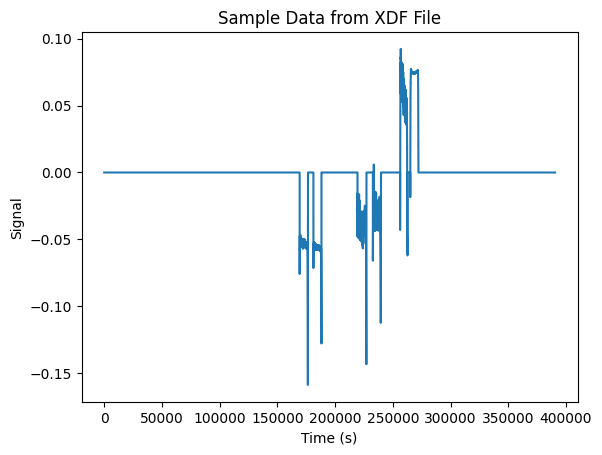

In [168]:
# Example: Plot the first few samples of the first stream
plt.plot(channel_2)
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Sample Data from XDF File')
plt.show()